# Imports

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import tensorflow_probability as tfp

# PascalVOC

In this kernel we will use imagenette to demo the Object Detection inference.

In [4]:
train_ds = tfds.load('voc', split='train')
test_ds = tfds.load('voc', split='validation')

Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incomplete2MM93T/voc-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incomplete2MM93T/voc-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incomplete2MM93T/voc-validation.tfrecord
Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


In [5]:
def preprocess(element):
    image = element["image"]
    return image

In [6]:
train_ds = train_ds.map(preprocess).shuffle(64)
test_ds = test_ds.map(preprocess)

In [7]:
for image in train_ds.take(1):
    print(image.shape)

(375, 500, 3)


# Object Detection API

Here we will be using the Mask-RCNN model to infer the objects from the images.

In [8]:
# Apply image detector on a single image.
detector = hub.load("https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1")

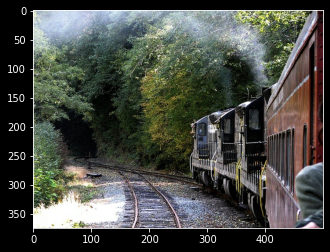

In [9]:
image = next(iter(train_ds))
plt.imshow(image)
plt.show()

In [10]:
detector_output = detector(image[None, ...])

In [11]:
boxes = detector_output["detection_boxes"]
scores = detector_output["detection_scores"]

# Define categorical distribution
dist = tfp.distributions.Categorical(probs=scores)

# Generate a sample from categorical distribution - this serves as an index
index = dist.sample(4)
boxes = tf.gather(boxes, tf.squeeze(index), axis=1)
boxes.shape

TensorShape([1, 4, 4])

In [12]:
colors = np.array([[1.0, 0.0, 0.0]])
image_bbox = tf.image.draw_bounding_boxes(
    tf.cast(image[None, ...], tf.float32)/255., boxes, colors
)

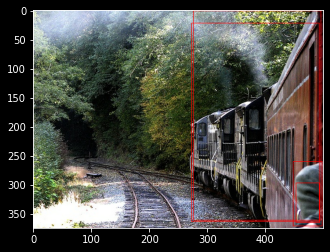

In [13]:
plt.imshow(tf.squeeze(image_bbox))
plt.show()

> We not only infer the bboxes we also crop the objects from the images.

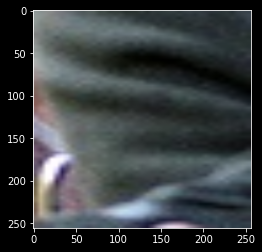

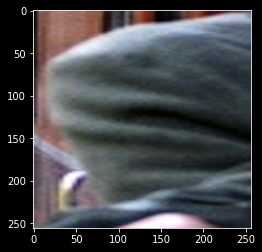

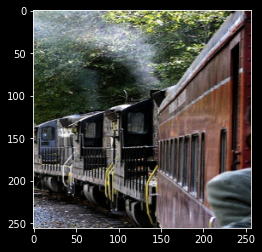

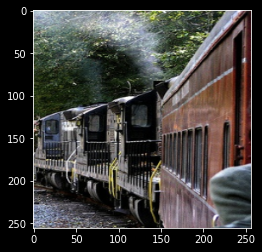

In [14]:
for box in boxes[0]:
    im_height, im_width, _ = image.shape
    ymin = box[0]
    xmin = box[1]
    ymax = box[2]
    xmax = box[3]
    (xminn, xmaxx, yminn, ymaxx) = int(xmin * im_width), int(xmax * im_width), int(ymin * im_height), int(ymax * im_height)
    cropped_image = tf.image.crop_to_bounding_box(
        image,
        yminn,
        xminn,
        ymaxx - yminn,
        xmaxx - xminn)
    crop = tf.image.resize(cropped_image, (256,256))
    plt.imshow(crop/255.)
    plt.show()